In [1]:
import numpy as np
np.random.seed(0)

# Evaluate on synthetic data

In [2]:
N = 100
nb_epoch = 2000
batch_size = 20
nb_features = 1024
Q = 1
D1 = 1  # first output
D2 = 1  # second output

In [3]:
def gen_data(N):
    X = np.random.randn(N, Q)
    w1 = 2.
    b1 = 8.
    sigma1 = 1e1  # ground truth
    Y1 = X.dot(w1) + b1 + sigma1 * np.random.randn(N, D1)
    w2 = 3
    b2 = 3.
    sigma2 = 1e0  # ground truth
    Y2 = X.dot(w2) + b2 + sigma2 * np.random.randn(N, D2)
    return X, Y1, Y2

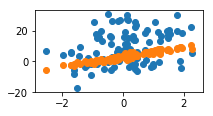

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

X, Y1, Y2 = gen_data(N)
plt.figure(figsize=(3, 1.5))
plt.scatter(X[:, 0], Y1[:, 0])
plt.scatter(X[:, 0], Y2[:, 0])
plt.show()

# Multi loss layer

In [ ]:
import keras
from keras.initializers import Constant
from keras.layers import Layer
from keras.models import Model
from keras import backend as K

# TODO: is Lambda needed ?

class AutoMultiLossLayer(Layer):
    def __init__(self, nb_outputs=2, **kwargs):
        self.nb_outputs = nb_outputs
        self.is_placeholder = True
        super(AutoMultiLossLayer, self).__init__(**kwargs)
        
    def build(self, input_shape=None):
        # initialise log_vars
        # keep the tensor used in the automatic weighting multi-loss
        self.log_vars = [self.add_weight(name='log_var' + str(idx), shape=(1,),
                                         initializer=Constant(2.), trainable=True)
                         for idx in range(self.nb_outputs)]
        super(AutoMultiLossLayer, self).build(input_shape)
        
    def call(self, inputs):
        # don't use inputs, returns internal weights
        return K.concatenate(self.log_vars, -1)

    def get_auto_weighted_loss(self, index, loss_func):
        assert 0 <= index < self.nb_outputs        
        # compute log(sigma^2)
        log_var = self.log_vars[index][0]
        # weighted loss for indexed weight
        def _loss(y_true, y_pred):
            # TODO: check if the formula is correct
            # Expected formula: (1 / (2 * sigma^2)) * loss_func(y_true, y_pred) + log(sigma^2)
            return K.exp(-log_var) * loss_func(y_true, y_pred) + log_var

        return _loss
        
    def get_sigma(self):
        # sigma = sqrt(exp(log_var))
        return [np.exp(K.get_value(log_var[0]))**0.5 for log_var in self.log_vars]
    
class AutoMultiLossWrapper(object):
    
    def __init__(self, model):
        self.original_model = model
        self.model = None
        self._auto_weighted_loss = False

    def compile(self, optimizer, loss, loss_weights=None, **kwargs):        
        self._auto_weighted_loss = False

        self.model = self.original_model
        # compute auto multi-loss only when loss is specified and 
        # there are atleast two outputs          
        if loss_weights == 'auto' and loss and len(self.model.outputs) > 1:
            n_losses = len(self.model.outputs)
            dummy_layer = AutoMultiLossLayer(n_losses, 
                                             name="auto_loss_w")(self.model.outputs)
            # add a dummy output to the graph to make the weights trainable
            self.model = Model(self.model.inputs, self.model.outputs + [dummy_layer])
            
            loss = self._get_losses(loss)

            self._auto_weighted_loss = True

        # fix parameter for keras api
        # by setting loss_weights to None, keras treats all losses equally
        if loss_weights == 'auto':
            loss_weights = None
                    
        self.model.compile(optimizer, loss, loss_weights=loss_weights, **kwargs)
    
    def _get_losses(self, loss):
        loss_factory = self.model.get_layer("auto_loss_w").get_auto_weighted_loss
        # deals with losses in the same way that keras model.compile method
        # allows compatibility
        if isinstance(loss, dict):
            loss_keys = sorted(loss.keys())

            new_loss = {name : loss_factory(loss_idx, keras.losses.get(loss.get(name)))
                        for loss_idx, name in enumerate(loss_keys)}
            # keras doesn't consider an output when its loss is set to None
            # skip dummy output
            new_loss['auto_loss_w'] = None

        elif isinstance(loss, list):
            new_loss = [loss_factory(loss_idx, keras.losses.get(name))
                        for loss_idx, name in enumerate(loss)]
            # skip dummy output
            new_loss.append(None)

        else:
            loss_func = keras.losses.get(loss)
            new_loss = [loss_factory(loss_idx, loss_func)
                        for loss_idx in range(len(self.original_model.outputs))]
            # skip dummy output
            new_loss.append(None)

        return new_loss
    
    def get_sigma(self):
        if self._auto_weighted_loss:
            return self.model.get_layer('auto_loss_w').get_sigma()
        else:
            return None

# Example model

In [6]:
from keras.layers import Input, Dense
from keras.models import Model

# model example
def get_prediction_model():
    inp = Input(shape=(Q,), name='input')
    x = Dense(nb_features, activation='relu')(inp)
    y1_pred = Dense(D1, name='y1')(x)
    y2_pred = Dense(D2, name='y2')(x)
    return Model(inp, [y1_pred, y2_pred])

auto_ml_wrapper = AutoMultiLossWrapper(get_prediction_model())

# identical to model.compile except that accepts loss_weights='auto'
auto_ml_wrapper.compile(optimizer='adam',
                        loss='mse',
#                        loss={'y1': 'mse', 'y2': 'mse'},
#                        loss=['mse', 'mse'],
                        loss_weights='auto')

In [7]:
# the extended model contains the dummy layer at the end
trainable_model = auto_ml_wrapper.model
trainable_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         2048        input[0][0]                      
__________________________________________________________________________________________________
y1 (Dense)                      (None, 1)            1025        dense_1[0][0]                    
__________________________________________________________________________________________________
y2 (Dense)                      (None, 1)            1025        dense_1[0][0]                    
__________________________________________________________________________________________________
auto_loss_

In [8]:
# train extended model
# deals with the dummy output internally
hist = trainable_model.fit(X, [Y1, Y2], epochs=nb_epoch, batch_size=batch_size, verbose=0)

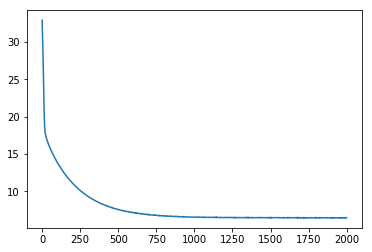

In [9]:
# auto weighted multi-loss
plt.plot(hist.history['loss'])

In [10]:
# Found standard deviations (ground truth is 10 and 1) ?
auto_ml_wrapper.get_sigma()

[9.990294133191263, 0.9211051765490255]

In [11]:
# original model can be used for predictions
prediction_model = auto_ml_wrapper.original_model
prediction_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         2048        input[0][0]                      
__________________________________________________________________________________________________
y1 (Dense)                      (None, 1)            1025        dense_1[0][0]                    
__________________________________________________________________________________________________
y2 (Dense)                      (None, 1)            1025        dense_1[0][0]                    
Total params: 4,098
Trainable params: 4,098
Non-trainable params: 0
_________________________________________